<a href="https://www.kaggle.com/code/hamadismail/ravdess-humanemotionrecognition-3d-cnn?scriptVersionId=140096088" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Data Preparation

In [282]:
import os
Root = "/kaggle/input/ravdess/"
os.chdir(Root)

In [283]:
ls

Actor_01/  Actor_05/  Actor_09/  Actor_13/  Actor_17/  Actor_21/
Actor_02/  Actor_06/  Actor_10/  Actor_14/  Actor_18/  Actor_22/
Actor_03/  Actor_07/  Actor_11/  Actor_15/  Actor_19/  Actor_23/
Actor_04/  Actor_08/  Actor_12/  Actor_16/  Actor_20/  Actor_24/


In [284]:
import os

# Initialize a variable to store the total number of samples
total_samples = 0

# Loop through subfolders in the main directory
for subfolder in os.listdir(Root):
    subfolder_path = os.path.join(Root, subfolder)
    if os.path.isdir(subfolder_path):
        # Count the number of files in the subfolder
        num_samples_in_subfolder = len(os.listdir(subfolder_path))
        total_samples += num_samples_in_subfolder

print("Total number of samples:", total_samples)


Total number of samples: 1440


# Importing Libraries

In [285]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

##  <center> 1. Ravdess Dataframe <center>


In [286]:
ravdess_directory_list = os.listdir(Root)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Root + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Root + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess/Actor_02/03-01-08-01-01-...
1,neutral,/kaggle/input/ravdess/Actor_02/03-01-01-01-01-...
2,disgust,/kaggle/input/ravdess/Actor_02/03-01-07-02-01-...
3,disgust,/kaggle/input/ravdess/Actor_02/03-01-07-01-01-...
4,neutral,/kaggle/input/ravdess/Actor_02/03-01-01-01-02-...


In [287]:
print(len(file_path))

1440


In [288]:
# creating Dataframe using ravdees dataframes we created so far.
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("/kaggle/working/data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess/Actor_02/03-01-08-01-01-...
1,neutral,/kaggle/input/ravdess/Actor_02/03-01-01-01-01-...
2,disgust,/kaggle/input/ravdess/Actor_02/03-01-07-02-01-...
3,disgust,/kaggle/input/ravdess/Actor_02/03-01-07-01-01-...
4,neutral,/kaggle/input/ravdess/Actor_02/03-01-01-01-02-...


## Data Visualisation and Exploration

In [289]:
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

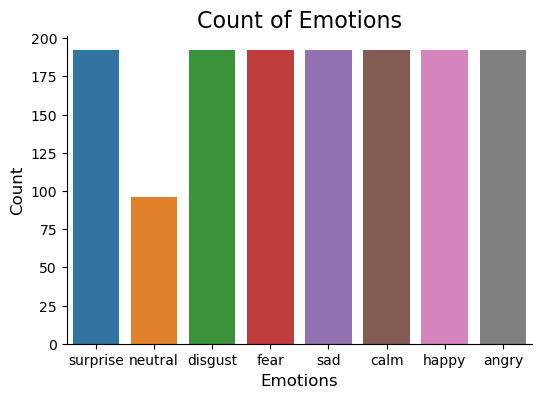

In [290]:
plt.figure(figsize=(6, 4))
plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='Emotions')
plt.xlabel('Emotions', size=12)
plt.ylabel('Count', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [291]:
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
    plt.plot(data)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

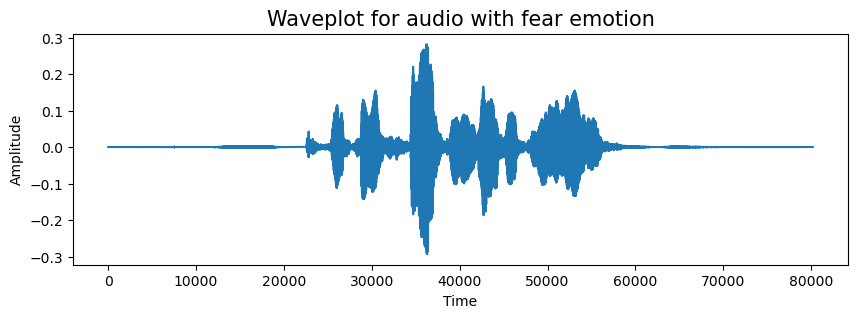

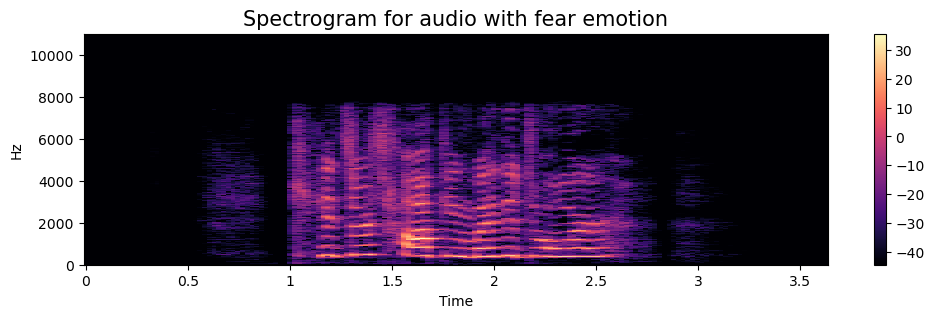

In [292]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation


In [293]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sr=22050, n_steps=2):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

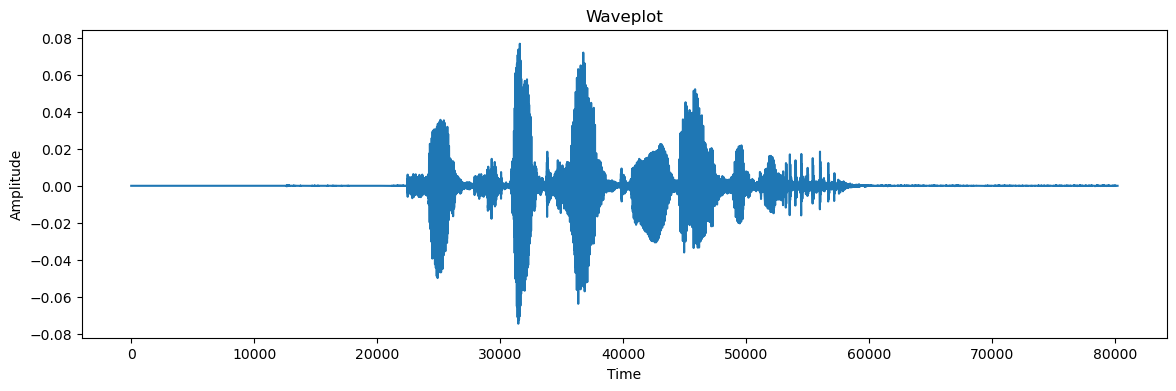

In [294]:
plt.figure(figsize=(14, 4))
plt.plot(data)
plt.title('Waveplot')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Audio(path)

#### 2. Noise Injection

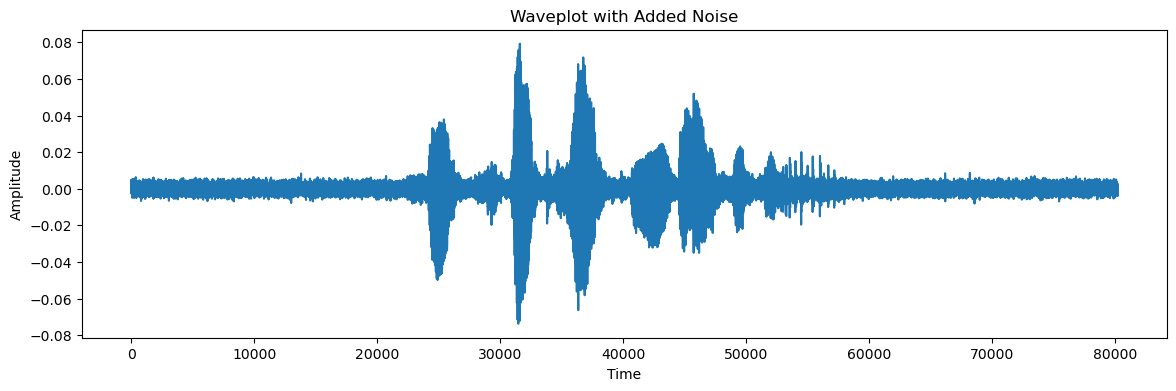

In [295]:
# x = np.random.normal(0, 0.1, len(data)) + data  # Add noise to the data

x = noise(data)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('Waveplot with Added Noise')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Audio(x, rate=sample_rate)

#### 3. Stretching

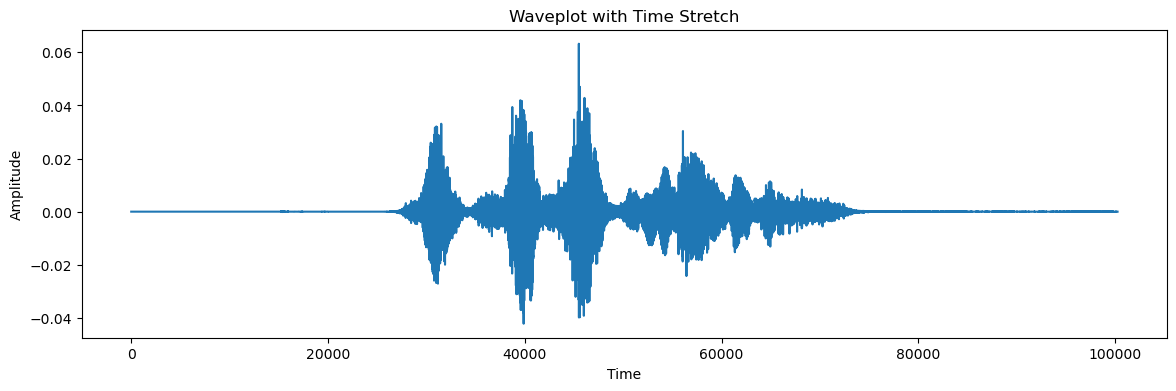

In [296]:
x = stretch(data, rate=0.8)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('Waveplot with Time Stretch')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Audio(x, rate=sample_rate)

#### 4. Shifting

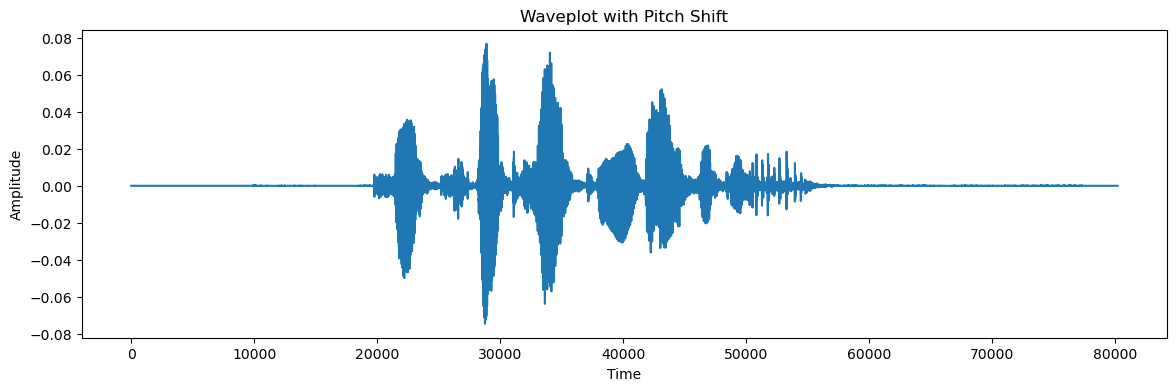

In [297]:
x = shift(data)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('Waveplot with Pitch Shift')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Audio(x, rate=sample_rate)

#### 5. Pitch

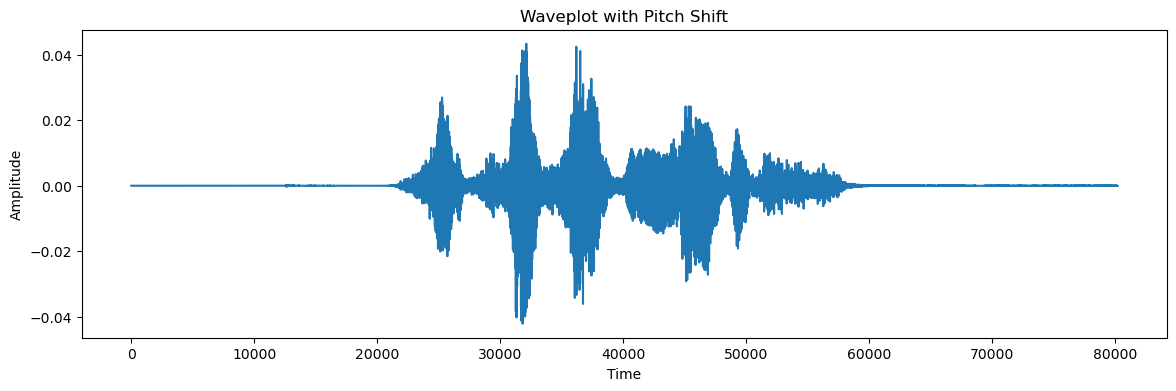

In [298]:
x = pitch(data, sr=22050, n_steps=2)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('Waveplot with Pitch Shift')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [299]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with shift
    shift_data = shift(data)
    res3 = extract_features(shift_data)
    result = np.vstack((result, res3)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res4 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res4)) # stacking vertically
    
    return result

In [300]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [301]:
num_samples = len(X)
num_time_steps = X[0].shape[0]  # Assuming all features have the same length
num_frequency_bins = 1  # 1D audio data has only one frequency bin

print("Number of samples:", num_samples)
print("Number of time steps:", num_time_steps)
print("Number of frequency bins:", num_frequency_bins)

len(X), len(Y), data_path.Path.shape

Number of samples: 5760
Number of time steps: 162
Number of frequency bins: 1


(5760, 5760, (1440,))

In [302]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('/kaggle/working/features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.214034,0.631756,0.623948,0.568991,0.528665,0.538974,0.655633,0.691172,0.691927,0.696634,...,3.701281e-14,2.976536e-14,2.442510e-14,2.098411e-14,1.866825e-14,1.699130e-14,1.669633e-14,1.616639e-14,1.504322e-14,surprise
1,0.293932,0.692550,0.699780,0.675010,0.654392,0.674735,0.713282,0.703504,0.678928,0.679524,...,1.595174e-04,1.477325e-04,1.371914e-04,1.501291e-04,1.357719e-04,1.332438e-04,1.451846e-04,1.411368e-04,1.498209e-04,surprise
2,0.215707,0.638718,0.630875,0.581892,0.535591,0.528874,0.643417,0.691284,0.696857,0.700454,...,8.760186e-11,8.261011e-11,7.874226e-11,7.558065e-11,7.301194e-11,7.100891e-11,6.944879e-11,6.836985e-11,6.767990e-11,surprise
3,0.180490,0.743045,0.709265,0.644338,0.642090,0.567635,0.512175,0.523160,0.656041,0.690112,...,2.476184e-06,4.517289e-09,2.355559e-14,1.332394e-14,9.743944e-15,9.747400e-15,6.472294e-15,3.730383e-15,7.668983e-16,surprise
4,0.203695,0.560744,0.541266,0.568667,0.605067,0.601439,0.616136,0.667533,0.719400,0.699431,...,3.263752e-14,2.590154e-14,2.146551e-14,1.837098e-14,1.624641e-14,1.472064e-14,1.400520e-14,1.316642e-14,1.273888e-14,neutral


* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [303]:
# X = Features.iloc[: ,:-1].values
X = np.array(Features.iloc[:, :-1].values).reshape(num_samples, num_time_steps, num_frequency_bins, 1)
Y = Features['labels'].values

In [304]:
from sklearn.preprocessing import OneHotEncoder
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [317]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4608, 162, 1, 1), (4608, 8), (1152, 162, 1, 1), (1152, 8))

In [318]:
from sklearn.preprocessing import StandardScaler

# Reshape the data to 2D
x_train_2d = x_train.reshape(x_train.shape[0], -1)
x_test_2d = x_test.reshape(x_test.shape[0], -1)

# Apply StandardScaler to the 2D data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_2d)
x_test_scaled = scaler.transform(x_test_2d)

# Reshape the scaled data back to 3D
x_train = x_train_scaled.reshape(x_train.shape[0], num_time_steps, num_frequency_bins, 1)
x_test = x_test_scaled.reshape(x_test.shape[0], num_time_steps, num_frequency_bins, 1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape


((4608, 162, 1, 1), (4608, 8), (1152, 162, 1, 1), (1152, 8))

## Modelling

In [307]:
import keras
from keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
import numpy as np

In [341]:
num_samples = 5760
num_time_steps = 162
num_frequency_bins = 1
num_channels = 1  # Single-channel audio
num_depth = 1

# Define the model
model = Sequential()

# First Conv3D layer
model.add(Conv3D(64, kernel_size=(3, 1, 1), strides=(1, 1, 1), padding='same', activation='relu', input_shape=(num_time_steps, num_frequency_bins, num_channels, 1)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 1, 1), strides=(2, 1, 1)))

# Fourth Conv3D layer
model.add(Conv3D(128, kernel_size=(3, 1, 1), strides=(1, 1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 1, 1), strides=(2, 1, 1)))

# Fourth Conv3D layer
model.add(Conv3D(256, kernel_size=(3, 1, 1), strides=(1, 1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 1, 1), strides=(2, 1, 1)))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_326 (Conv3D)         (None, 162, 1, 1, 64)     256       
                                                                 
 batch_normalization_315 (Ba  (None, 162, 1, 1, 64)    256       
 tchNormalization)                                               
                                                                 
 max_pooling3d_315 (MaxPooli  (None, 81, 1, 1, 64)     0         
 ng3D)                                                           
                                                                 
 conv3d_327 (Conv3D)         (None, 81, 1, 1, 128)     24704     
                                                                 
 batch_normalization_316 (Ba  (None, 81, 1, 1, 128)    512       
 tchNormalization)                                               
                                                    

In [343]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
72/72 [==============================] - 7s 88ms/step - loss: 1.4894 - accuracy: 0.4225 - val_loss: 2.1316 - val_accuracy: 0.2439 - lr: 0.0010
Epoch 2/100
72/72 [==============================] - 6s 89ms/step - loss: 1.3732 - accuracy: 0.4722 - val_loss: 1.7140 - val_accuracy: 0.3819 - lr: 0.0010
Epoch 3/100
72/72 [==============================] - 6s 86ms/step - loss: 1.3042 - accuracy: 0.4950 - val_loss: 1.4949 - val_accuracy: 0.4826 - lr: 0.0010
Epoch 4/100
72/72 [==============================] - 6s 86ms/step - loss: 1.1483 - accuracy: 0.5584 - val_loss: 1.3752 - val_accuracy: 0.4974 - lr: 0.0010
Epoch 5/100
72/72 [==============================] - 6s 87ms/step - loss: 1.0865 - accuracy: 0.5647 - val_loss: 1.1614 - val_accuracy: 0.5807 - lr: 0.0010
Epoch 6/100
72/72 [==============================] - 6s 86ms/step - loss: 0.9475 - accuracy: 0.6287 - val_loss: 1.0149 - val_accuracy: 0.6302 - lr: 0.0010
Epoch 7/100
72/72 [==============================] - 6s 90ms/step - lo

36/36 [==============================] - 1s 12ms/step - loss: 0.8723 - accuracy: 0.8168
Accuracy of our model on test data :  81.68402910232544 %


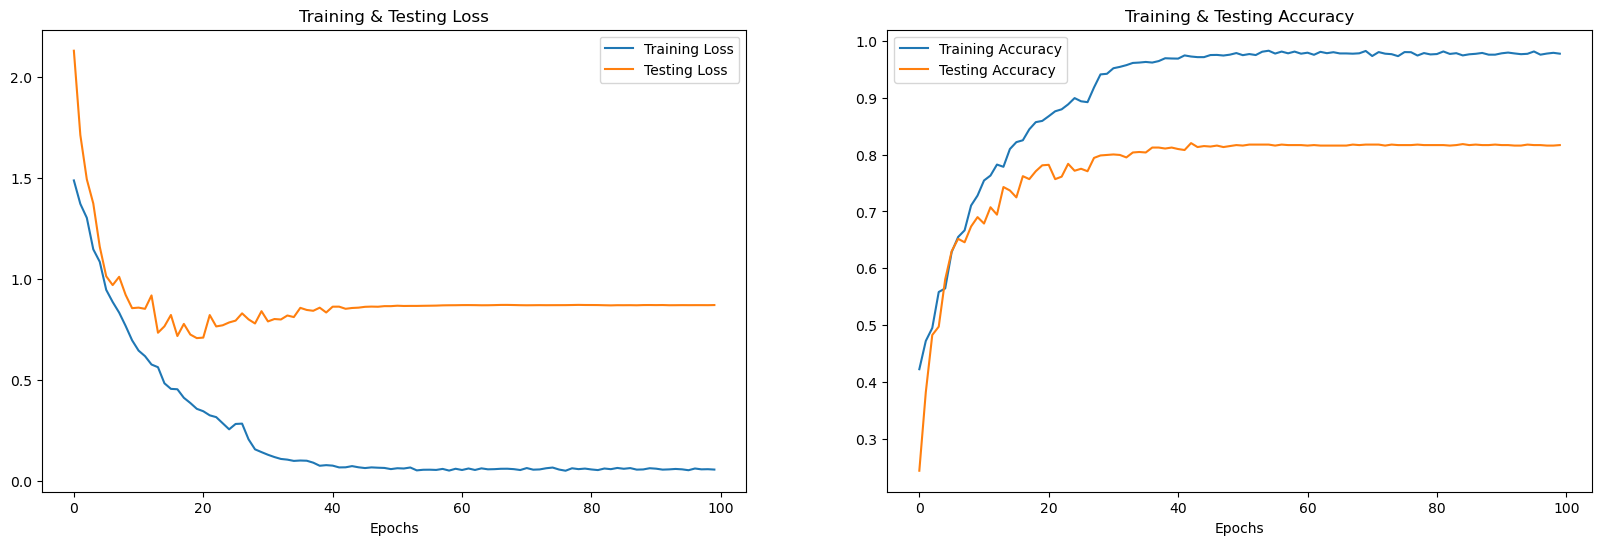

In [344]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [345]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

36/36 [==============================] - 1s 12ms/step


In [346]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,sad,sad
1,fear,fear
2,disgust,disgust
3,happy,happy
4,surprise,surprise
5,sad,sad
6,calm,calm
7,calm,calm
8,calm,calm
9,neutral,neutral


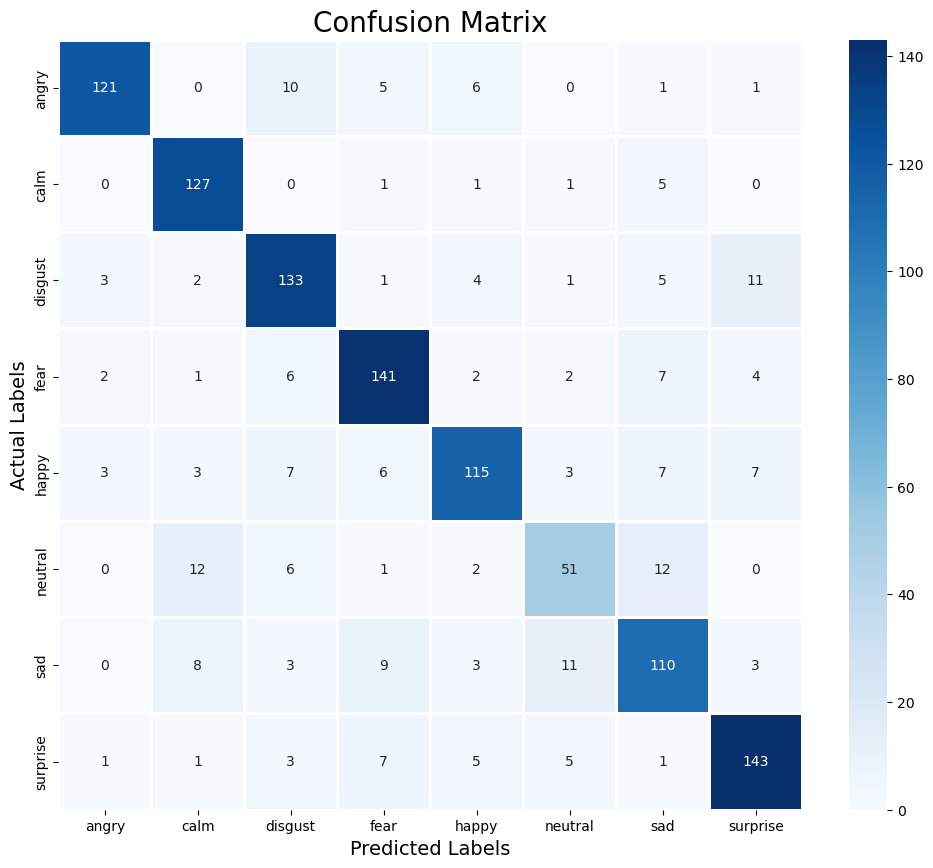

In [347]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [348]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

       angry       0.93      0.84      0.88       144
        calm       0.82      0.94      0.88       135
     disgust       0.79      0.83      0.81       160
        fear       0.82      0.85      0.84       165
       happy       0.83      0.76      0.80       151
     neutral       0.69      0.61      0.65        84
         sad       0.74      0.75      0.75       147
    surprise       0.85      0.86      0.85       166

    accuracy                           0.82      1152
   macro avg       0.81      0.81      0.81      1152
weighted avg       0.82      0.82      0.82      1152

